In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import optimizers
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D 
from keras.utils import np_utils
from keras.utils import plot_model
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from itertools import chain
from tensorflow.keras import initializers
from keras.layers import concatenate

from tqdm import tqdm
from gensim.models import fasttext, KeyedVectors, FastText
from gensim.test.utils import datapath
import os, re, csv, math, codecs, pickle, nltk
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from matplotlib import rcParams
from gensim.test.utils import get_tmpfile

In [2]:
# OPEN DATA from pickle files
# x_train, x_test, y_train, y_test
# x = tweets data
# y = tweet labels data

with open('x_train.pkl', 'rb') as file:
    x_train = pickle.load(file)
    
with open('x_test.pkl', 'rb') as file:
    x_test = pickle.load(file)

with open('y_train.pkl', 'rb') as file:
    y_train = pickle.load(file)
    
with open('y_test.pkl', 'rb') as file:
    y_test = pickle.load(file)


In [3]:
#get tweets as x 

df_x_train = pd.DataFrame(x_train)
df_x_test = pd.DataFrame(x_test)
#x_train
#x_test

#get max length of sentences

list_len = [len(i) for i in x_train]
index_of_max = np.argmax(np.array(list_len))
max_sentence_len = list_len[index_of_max]

#flatten the x_train for fitting in the model tokenizer
x_train_fit = list(chain.from_iterable(x_train))

#get labels as y
df_ytrain = pd.DataFrame(y_train, columns = ['Label'])
df_ytest = pd.DataFrame(y_test, columns = ['Label'])

mapping = {'Non-hate': 0, 'Hate': 1}
df_ytrain = df_ytrain.replace({'Label': mapping})
df_ytest = df_ytest.replace({'Label': mapping})

train_y = df_ytrain['Label'].tolist()
test_y = df_ytest['Label'].tolist()

np_train_y = np.asarray(train_y)
np_test_y = np.asarray(test_y)
df_ytrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3584 entries, 0 to 3583
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Label   3584 non-null   int64
dtypes: int64(1)
memory usage: 28.1 KB


In [4]:
# DATA VECTORIZATION


#process tweets before vectorization
x_train_sequences = []
x_test_sequences = []

for i in range(len(x_train)):
    tweet = " ".join(x_train[i])
    x_train_sequences.append(tweet)
    
for i in range(len(x_test)):
    tweet = " ".join(x_test[i])
    x_test_sequences.append(tweet)

tokenizer = Tokenizer(num_words=100000, char_level=False)
tokenizer.fit_on_texts(x_train_fit)

word_seq_train_x = tokenizer.texts_to_sequences(x_train_sequences)
word_seq_test_x = tokenizer.texts_to_sequences(x_test_sequences)

print(x_train_sequences[0])
print(word_seq_train_x[0])

#assign word_index from tokenizer to get the training dictionary 
#to check with the fasttext embeddings lateron
word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))

#pad sequences
word_seq_train = keras.preprocessing.sequence.pad_sequences(word_seq_train_x, maxlen=max_sentence_len)
word_seq_test = keras.preprocessing.sequence.pad_sequences(word_seq_test_x, maxlen=max_sentence_len)
print(len(word_seq_train))
print(len(word_seq_test))

single piece shit whose supporting family bigtime corrupts killers place earth faves repenting threathening ms robredo's life right ohhhh killer spotted
[987, 1147, 988, 989, 462, 147, 4303, 4304, 4305, 587, 4306, 4307, 4308, 4309, 1373, 89, 463, 124, 4310, 4311, 2797]
dictionary size:  10243
3584
1536


In [5]:
# LOAD FASTTEXT CORPUS
ft_model = fasttext.load_facebook_model(datapath("cc.tl.300.bin"))

In [6]:
# INCREMENT FASTTEXT CORPUS
sent1 = x_train

ft_model.build_vocab(sent1, update=True)
ft_model.train(sent1, total_examples=len(sent1), epochs=ft_model.epochs)

(28995, 89902)

In [7]:
# EMBEDDING MATRIX
print('preparing embedding matrix...')
words_not_found = []
nb_words = len(word_index)+1
embedding_matrix = np.zeros((nb_words, 300))
for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = ft_model.wv[word]
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))
print(words_not_found)
print(word_seq_train[0].shape)

preparing embedding matrix...
number of null word embeddings: 2
[]
(36,)


In [68]:
#CNN MODEL TEST

print("training CNN ...")
model = Sequential()
model.add(Embedding(nb_words, 300,
          weights=[embedding_matrix], input_length=max_sentence_len, trainable=False))
model.add(Conv1D(256, 2, padding='same', activation='relu'))
model.add(MaxPooling1D(2,2))
model.add(Conv1D(64, 4, padding='same', activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))  #binary label non hate or hate

adam = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

training CNN ...
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 36, 300)           3073200   
                                                                 
 conv1d_10 (Conv1D)          (None, 36, 256)           153856    
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 18, 256)          0         
 1D)                                                             
                                                                 
 conv1d_11 (Conv1D)          (None, 18, 64)            65600     
                                                                 
 global_max_pooling1d_5 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dropout_5 (Dropout)         (None, 6

In [69]:
model_history = model.fit(word_seq_train, np_train_y, batch_size = 32, epochs = 5, verbose=2, validation_split = 0.1)

Epoch 1/5
101/101 - 2s - loss: 0.5885 - accuracy: 0.6834 - val_loss: 0.4644 - val_accuracy: 0.8106 - 2s/epoch - 19ms/step
Epoch 2/5
101/101 - 1s - loss: 0.4337 - accuracy: 0.8056 - val_loss: 0.5051 - val_accuracy: 0.7688 - 1s/epoch - 12ms/step
Epoch 3/5
101/101 - 1s - loss: 0.3742 - accuracy: 0.8350 - val_loss: 0.4022 - val_accuracy: 0.8329 - 1s/epoch - 12ms/step
Epoch 4/5
101/101 - 1s - loss: 0.3106 - accuracy: 0.8695 - val_loss: 0.3935 - val_accuracy: 0.8412 - 1s/epoch - 12ms/step
Epoch 5/5
101/101 - 1s - loss: 0.2885 - accuracy: 0.8828 - val_loss: 0.4045 - val_accuracy: 0.8412 - 1s/epoch - 12ms/step


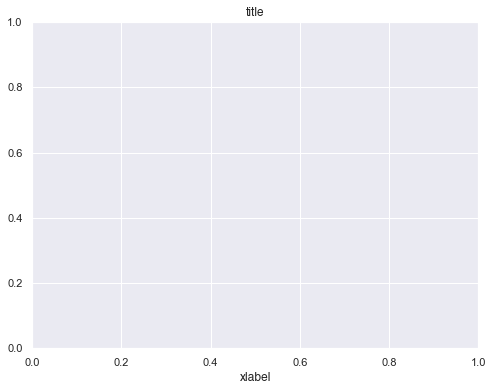

In [70]:
#plot configuration
CB91_Blue = '#2CBDFE'
CB91_Green = '#47DBCD'
CB91_Pink = '#F3A0F2'
CB91_Purple = '#9D2EC5'
CB91_Violet = '#661D98'
CB91_Amber = '#F5B14C'

color_list = [CB91_Blue, CB91_Amber]

csfont = {'fontname':'Helvetica'}
hfont = {'fontname':'Helvetica'}

plt.title('title',**csfont)
plt.xlabel('xlabel', **hfont)
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=color_list)

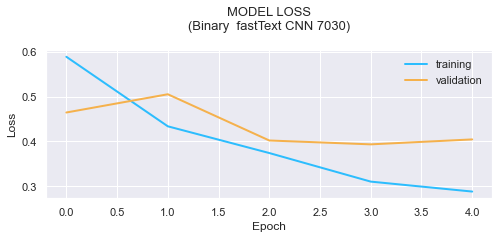

In [71]:
# plot loss during training
plt.subplot(212)
plt.title('MODEL LOSS\n(Binary  fastText CNN 7030)\n', fontsize = 13)
plt.plot(model_history.history['loss'], label='training', linewidth=2)
plt.plot(model_history.history['val_loss'], label='validation', linewidth=2)
plt.legend(frameon=False)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

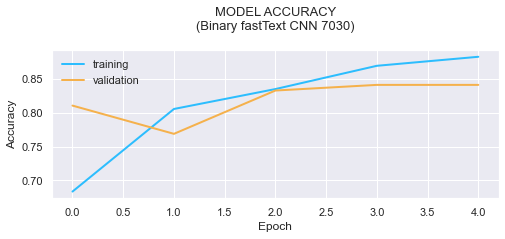

In [72]:
# plot accuracy during training
plt.subplot(212)
plt.title('MODEL ACCURACY\n(Binary fastText CNN 7030)\n', fontsize = 13)
plt.plot(model_history.history['accuracy'], label='training', linewidth=2)
plt.plot(model_history.history['val_accuracy'], label='validation', linewidth=2)
plt.legend(frameon=False)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [73]:
model.save('fasttextcnn.h5')
#model = load_model('best_model.h5')

In [74]:
pred_labels_train = model.predict(word_seq_train)
ytrain_result = (pred_labels_train > 0.5).astype(int)

112/112 [==============================] - 1s 5ms/step


In [75]:
pred_labels_test = model.predict(word_seq_test)
ytest_result = (pred_labels_test > 0.5).astype(int)

48/48 [==============================] - 0s 4ms/step


In [81]:
##### Step 7 - Model Performance Summary

print("")
print('-------------------- Model Summary --------------------')
model.summary() # print model summary
print("")
print('---------- Evaluation on Training Data ----------')
print(classification_report(np_train_y, ytrain_result, digits = 4))
print("")

print('---------- Evaluation on Test Data ----------')
print(classification_report(np_test_y, ytest_result, digits = 4))
print("")


-------------------- Model Summary --------------------
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 36, 300)           3073200   
                                                                 
 conv1d_10 (Conv1D)          (None, 36, 256)           153856    
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 18, 256)          0         
 1D)                                                             
                                                                 
 conv1d_11 (Conv1D)          (None, 18, 64)            65600     
                                                                 
 global_max_pooling1d_5 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                               

[[621 157]
 [110 648]]


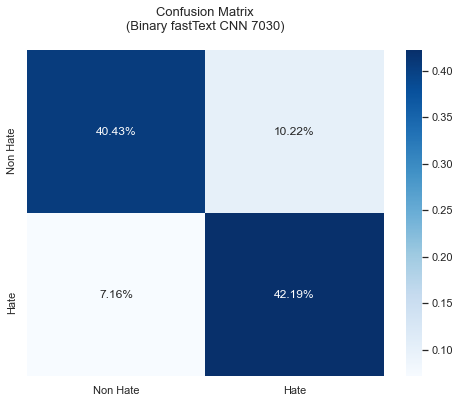

In [82]:
cf_matrix = confusion_matrix(np_test_y, ytest_result)
print(cf_matrix)
sns.set(rc={"figure.figsize":(8, 6)})
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, xticklabels = ['Non Hate', 'Hate'], yticklabels = ['Non Hate', 'Hate'],
            fmt='.2%', cmap='Blues')

plt.title('Confusion Matrix\n(Binary fastText CNN 7030)\n', fontsize = 13) # title with fontsize 20
plt.show()

In [83]:
test_results = pd.DataFrame(list(zip(x_test,ytest_result, pred_labels_test)), columns = ['Tweet','Prediction', 'Prediction Value'])
test_results 

,Tweet,Prediction,Prediction Value
0,"[future, president, iktr, gaga, stans, spittin...",[1],[0.81015676]
1,"[tulungan, nating, manalo, sara, duterte, dara...",[0],[0.043186326]
2,"[ayan, spoon, feed, sau, ha]",[1],[0.96028453]
3,"[nagtataka, okay, lang, suportahan, communist,...",[1],[0.88841116]
4,"[obviously, attend, smni, debate, owner, netwo...",[1],[0.52109295]
...,...,...,...
1531,"[makakalimutan, itong, h2h, grand, rally, napu...",[0],[0.20610619]
1532,"[daughters, girls, anong, klaseng, katangahan,...",[1],[0.9658182]
1533,"[even, signature, figure, liberal, party, proj...",[1],[0.92429537]
1534,"[best, job, woman]",[0],[0.00052601635]


In [84]:
#Saving labels to be used on other files
true_labels = open('true_labels.pkl', 'wb')
pickle.dump(np_test_y,true_labels)
true_labels.close()

predicted_labels = open('fastTextCNN_predicted_labels.pkl', 'wb')
pickle.dump(ytest_result,predicted_labels)
predicted_labels.close()

fastTextCNN_test_results = open('fastTextCNN_test_results.pkl', 'wb')
pickle.dump(test_results,fastTextCNN_test_results)
fastTextCNN_test_results.close()